-------------
# １．ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_X_y

# タイピングのサポート
from typing import Optional


# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
# ２．実験設定

In [2]:
### 実験データの設定 ###
TARGET = "visit"  #'conversion', 'visit'
TRAIN_SIZE = 100000
TEST_SIZE = 100000

### 実験設定 ###
N_TRIALS = 10000  # 試行回数（標本平均を求める回数）
SAMPLE_SIZE = 100  # 標本サイズ
RANDOM_STATE = 0  # 乱数シード
SEED = 0

-----------
# ３．データの前処理

## 3.1 データ読み込み

In [3]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\criteo-uplift-v2.1.csv.gz", sep=",", header=None
)

df_all.columns = df_all.iloc[0]  # 0行目を列名にする
df_all = df_all[1:].reset_index(drop=True)

column_names = df_all.columns.tolist()
print("列名:", column_names)

df_treatment = df_all[df_all["treatment"] == 1]
df_treatment_0 = df_treatment[df_treatment[TARGET] == 0]
df_treatment_1 = df_treatment[df_treatment[TARGET] == 1]

features_list = [
    "f0",
    "f1",
    "f2",
    "f3",
    "f4",
    "f5",
    "f6",
    "f7",
    "f8",
    "f9",
    "f10",
    "f11",
]
ALL_FEATURES_INDEX = [i for i in range(len(features_list))]

df_train_0 = df_treatment_0.iloc[: int(TRAIN_SIZE / 2)]
df_train_1 = df_treatment_1.iloc[: int(TRAIN_SIZE / 2)]
df_test_0 = df_treatment_0.iloc[
    int(TRAIN_SIZE / 2) : int(TRAIN_SIZE / 2 + TEST_SIZE / 2)
]
df_test_1 = df_treatment_1.iloc[
    int(TRAIN_SIZE / 2) : int(TRAIN_SIZE / 2 + TEST_SIZE / 2)
]

df_train = pd.concat([df_train_0, df_train_1])
df_test = pd.concat([df_test_0, df_test_1])

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_8968\1097840519.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(


列名: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure']


In [4]:
df_train = df_train.apply(lambda col: pd.to_numeric(col, errors="coerce"))
df_test = df_test.apply(lambda col: pd.to_numeric(col, errors="coerce"))


## 3.3 X, y に分割

In [5]:
X_train = df_train[features_list].to_numpy()
y_train = df_train[TARGET].to_numpy()

X_test = df_test[features_list].to_numpy()
y_test = df_test[TARGET].to_numpy()

-----------------------------
# 4. 共変量の選択（訓練データ)

In [6]:
X_train_df = pd.DataFrame(X_train)
y_train_series = pd.Series(y_train)

correlations = X_train_df.corrwith(y_train_series)

# 最も相関が高い変数の選択
most_correlated_var_index = correlations.abs().idxmax()  # 絶対値が最大の変数を取得
max_correlation = correlations[most_correlated_var_index]

print(
    f"{TARGET}と最も相関の高い変数のインデックス: {most_correlated_var_index}, 相関係数: {round(max_correlation, 3)}"
)

visitと最も相関の高い変数のインデックス: 8, 相関係数: -0.76


-----------------
# 5．CUPED

## 5.1 αの計算（訓練データ）

In [7]:
scaler = StandardScaler()
scaled_cov = scaler.fit_transform(X_train[:, [most_correlated_var_index]])
alpha = np.cov(y_train, scaled_cov[:, 0])[0, 1] / np.var(scaled_cov[:, 0])

print("alpha : ", alpha)

alpha :  -0.37995222740328327


## 5.2 CUPEDの実施（テストデータ）

In [8]:
def cauculate_var_cuped(
    X: NDArray,
    y: NDArray,
    seed: int,
    alpha: float,
    most_correlated_var_index: int,
    sample_size: int,
    n_trials: int,
) -> float:
    np.random.seed(seed)

    scaler = StandardScaler()
    scaled_cov = scaler.fit_transform(X[:, [most_correlated_var_index]])
    y_cuped = y - alpha * scaled_cov[:, 0]

    sample_means = np.zeros(n_trials)
    for i in range(n_trials):
        # y_cupedからランダムにサンプリング
        sample = np.random.choice(y_cuped, sample_size, replace=False)
        sample_means[i] = sample.mean()

    # 標本分散を計算
    variance = np.var(sample_means)

    return variance, sample_means

-------------------
# 6. COSS

In [9]:
def cauculate_var_coss(
    X: NDArray,
    y: NDArray,
    seed: int,
    most_correlated_var_index: int,
    sample_size: int,
    n_trials: int,
) -> float:
    np.random.seed(seed)

    X = pd.DataFrame(X)
    y = pd.Series(y)

    sample_means_t = np.zeros(n_trials)
    sample_means_c = np.zeros(n_trials)
    for i in range(n_trials):
        rows = np.random.choice(X.index, sample_size * 2, replace=False)

        sample_X = X.iloc[rows, most_correlated_var_index]
        sample_X_sorted = sample_X.sort_values(ascending=False)

        rows_t = sample_X_sorted.index[::2]
        rows_c = sample_X_sorted.index[1::2]

        sample_t = y.loc[rows_t].to_numpy()
        sample_c = y.loc[rows_c].to_numpy()

        sample_means_t[i] = sample_t.mean()
        sample_means_c[i] = sample_c.mean()

    variance_t = np.var(sample_means_t)
    variance_c = np.var(sample_means_c)

    return variance_t, variance_c, sample_means_t

----------------
# 7. 評価

In [10]:
def cauculate_var_random(y: NDArray, seed: int, n_trials: int, sample_size) -> float:
    np.random.seed(seed)
    y_hats = []
    for i in range(n_trials):
        sample = np.random.choice(y, sample_size, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    var_random = np.array(y_hats).var()

    return var_random

In [11]:
VAR_RANDOM_TRAIN = cauculate_var_random(
    y=y_train, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)
VAR_RANDOM_TEST = cauculate_var_random(
    y=y_test, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)

var_cuped_train, _ = cauculate_var_cuped(
    X=X_train,
    y=y_train,
    seed=SEED,
    alpha=alpha,
    most_correlated_var_index=most_correlated_var_index,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
)

var_cuped_test, Y_HATS_CUPED = cauculate_var_cuped(
    X=X_test,
    y=y_test,
    seed=SEED,
    alpha=alpha,
    most_correlated_var_index=most_correlated_var_index,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
)

var_coss_train_t, var_coss_train_c, _ = cauculate_var_coss(
    X=X_train,
    y=y_train,
    seed=SEED,
    most_correlated_var_index=most_correlated_var_index,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
)

var_coss_test_t, var_coss_test_c, Y_HATS_COSS = cauculate_var_coss(
    X=X_test,
    y=y_test,
    seed=SEED,
    most_correlated_var_index=most_correlated_var_index,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
)

### 確認用

In [12]:
print("var_random_train =", VAR_RANDOM_TRAIN)
print("var_random_test =", VAR_RANDOM_TEST)

var_random_train = 0.0025041684160000003
var_random_test = 0.0025041684160000003


In [13]:
print(Y_HATS_COSS)
print(Y_HATS_CUPED)


[0.44 0.46 0.47 ... 0.5  0.56 0.49]
[0.53450614 0.52055636 0.42766548 ... 0.45180267 0.53289266 0.5278181 ]


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_8968\2390335445.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["CUPED"])


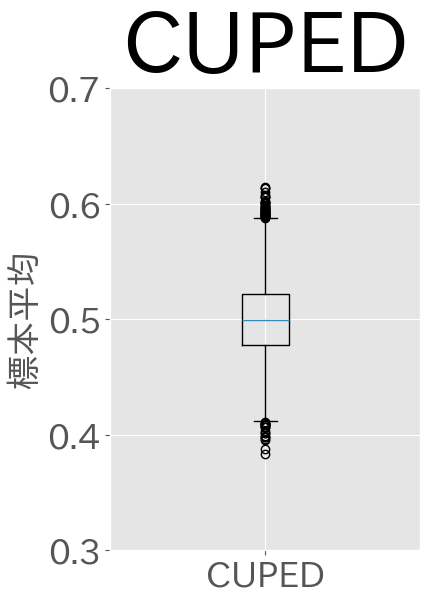

In [19]:
# データをリストに変換
data = Y_HATS_CUPED

# 箱ひげ図を作成
plt.figure(figsize=(4, 6))
plt.boxplot(data, labels=["CUPED"])

# 図のタイトルとラベル
plt.title("CUPED", fontsize=60)
plt.ylabel("標本平均", fontsize=25)
plt.tick_params(axis="both", labelsize=25)
plt.ylim(0.3, 0.7)

# グラフを表示
plt.show()


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_8968\3118572389.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["COSS"])


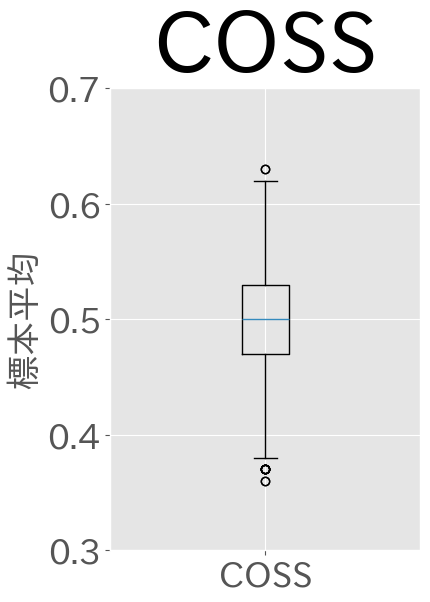

In [20]:
# データをリストに変換
data = Y_HATS_COSS

# 箱ひげ図を作成
plt.figure(figsize=(4, 6))
plt.boxplot(data, labels=["COSS"])

# 図のタイトルとラベル
plt.title("COSS", fontsize=60)
plt.ylabel("標本平均", fontsize=25)
plt.tick_params(axis="both", labelsize=25)
plt.ylim(0.3, 0.7)

# グラフを表示
plt.show()


In [16]:
# CUPED の分散削減率
reduction_rate_cuped = (1 - var_cuped_test / VAR_RANDOM_TEST) * 100
print("CUPEDの分散削減率 : ", reduction_rate_cuped)

reduction_rate_coss_t = (1 - var_coss_test_t / VAR_RANDOM_TEST) * 100
reduction_rate_coss_c = (1 - var_coss_test_c / VAR_RANDOM_TEST) * 100
print("COSSの分散削減率(test) : ", reduction_rate_coss_t)
print("COSSの分散削減率(control) : ", reduction_rate_coss_c)

CUPEDの分散削減率 :  57.90780053289455
COSSの分散削減率(test) :  33.65036930487345
COSSの分散削減率(control) :  33.57478017964108


In [17]:
print("var_cuped_train =", var_cuped_train)
print("var_cuped_test =", var_cuped_test)

var_cuped_train = 0.0010519846099158504
var_cuped_test = 0.001054059564654975


In [18]:
print("var_coss_train =", var_coss_train_t)
print("var_coss_test =", var_coss_test_t)

var_coss_train = 0.0017025072160000005
var_coss_test = 0.0016615064960000005
